<a href="https://colab.research.google.com/github/Sangram-Rout/me314/blob/main/Final%20Project_Dragonfly%20intercepting%20prey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import sympy as sym
from sympy.abc import t
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.linalg
import time

#######################
# Custom latex printing
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

####################
# Simulation helpers
def integrate(f,x0,dt,t):
    """
    This function takes in an initial condition x0 and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a vector x at the future time step.
    """
    k1=dt*f(x0,t)
    k2=dt*f(x0+k1/2.,t)
    k3=dt*f(x0+k2/2.,t)
    k4=dt*f(x0+k3,t)
    xnew=x0+(1/6.)*(k1+2.*k2+2.*k3+k4)
    return xnew

############
# Simulating
def simulate(f,x0,tspan,dt, phi_condition=lambda x: False, impact_update=lambda x: x):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. Additionally, it takes in a function
    phi_condition(x) that evaluates whether or not a system is undergoing
    impacts. Finally, impact_update(x) is a function that applies the 
    update law. simulate_impact outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        if phi_condition(x):
            xtraj[:,i]=integrate(f,impact_update(x),dt,tvec[i]) # I pass the current time to the integrator now
        else:
            xtraj[:,i]=integrate(f,x,dt,tvec[i])
        x = np.copy(xtraj[:,i])
    return xtraj

##################
# Helper Functions
def rectangle(xc,yc,tht,ll,ww):
    wax = np.array([0,0,1])
    rotMat = T(wax,tht,np.array([xc,yc,0]), False)
    p1 = np.dot(rotMat,T(wax,0,np.array([ll/2.,ww/2.,0]), False))
    p2 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,ww/2.,0]), False))
    p3 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,-ww/2.,0]), False))
    p4 = np.dot(rotMat,T(wax,0,np.array([ll/2.,-ww/2.,0]), False))
    return np.squeeze(np.array([p1[0,3],p1[1,3],p2[0,3],p2[1,3],
                                p3[0,3],p3[1,3],p4[0,3],p4[1,3]],dtype=np.float64))
def rectangle_t(xto,yto,tht,ll,ww):
    wax = np.array([0,0,1])
    rotMat = T(wax,tht,np.array([xto,yto,0]), False)
    p1 = np.dot(rotMat,T(wax,0,np.array([ll/2.,0,0]), False))
    p2 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,0,0]), False))
    p3 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,-ww,0]), False))
    p4 = np.dot(rotMat,T(wax,0,np.array([ll/2.,-ww,0]), False))
    return np.squeeze(np.array([p1[0,3],p1[1,3],p2[0,3],p2[1,3],
                                p3[0,3],p3[1,3],p4[0,3],p4[1,3]],dtype=np.float64))
def rectangle_b(xbo,ybo,tht,ll,ww):
    wax = np.array([0,0,1])
    rotMat = T(wax,tht,np.array([xbo,ybo,0]), False)
    p1 = np.dot(rotMat,T(wax,0,np.array([ll/2.,ww,0]), False))
    p2 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,ww,0]), False))
    p3 = np.dot(rotMat,T(wax,0,np.array([-ll/2.,0,0]), False))
    p4 = np.dot(rotMat,T(wax,0,np.array([ll/2.,0,0]), False))
    return np.squeeze(np.array([p1[0,3],p1[1,3],p2[0,3],p2[1,3],
                                p3[0,3],p3[1,3],p4[0,3],p4[1,3]],dtype=np.float64))
def hat(w,use_sym=True):
    if use_sym:
        what = sym.Matrix([[    0,-w[2], w[1]],
                           [ w[2],    0,-w[0]],
                           [-w[1], w[0],   0]])
    else:
        what = np.array([[    0,-w[2], w[1]],
                         [ w[2],    0,-w[0]],
                         [-w[1], w[0],   0]])
    return what

def unhat(what,use_sym=True):
    if use_sym:
        w = sym.Matrix([what[2,1],what[0,2],what[1,0]])
    else:
        w = np.array([what[2,1],what[0,2],what[1,0]])
    return w

def rot(w,theta,use_sym=True):
    if use_sym:
        rotMat = sym.Matrix(sym.simplify(sym.exp(hat(w,use_sym)*theta)))
        for i in range(rotMat.shape[0]):
            for j in range(rotMat.shape[1]):
                rotMat[i,j] = sym.simplify(rotMat[i,j].rewrite(sym.sin)) # Simplification made because sympy seems to have
                                                                         # issues applying the Euler identity so I force it
                                                                         # to recognize it.
    else:
        rotMat = scipy.linalg.expm(hat(w,use_sym)*theta)
    return rotMat

def T(w,th,p,use_sym=True):
    R = rot(w,th,use_sym)
    if use_sym:
        Tmat = sym.Matrix([[R[0,0],R[0,1],R[0,2],p[0]],
                           [R[1,0],R[1,1],R[1,2],p[1]],
                           [R[2,0],R[2,1],R[2,2],p[2]],
                           [     0,     0,     0,   1]])
    else:
        Tmat = np.array([[R[0,0],R[0,1],R[0,2],p[0]],
                         [R[1,0],R[1,1],R[1,2],p[1]],
                         [R[2,0],R[2,1],R[2,2],p[2]],
                         [     0,     0,     0,   1]])
    return Tmat

def pos(T,use_sym=True):
    if use_sym:
        p = sym.Matrix([T[0,3],T[1,3],T[2,3]])
    else:
        p = np.array([T[0,3],T[1,3],T[2,3]])
    return p

In [ ]:
# Configuration variable
m,R,g,h,τ = sym.symbols('m R g h τ')
th = sym.Function(r'\theta')(t)
psi = sym.Function(r'\psi')(t)
tau = sym.Function(r'\tau')(t)
tau_m = sym.Function(r'\tau^-')(t)
tau_p = sym.Function(r'\tau^+')(t)
Lam = sym.Function(r'Lam')(t)
k1, k2 = sym.symbols('k_1 k_2')
mb= sym.symbols('m_b') 

#subdict = {mb:2}
xb = sym.Function(r'x_b')(t)
yb = sym.Function(r'y_b')(t)

q = sym.Matrix([xb,yb,th]) 
qdot = q.diff(t)
qddot = qdot.diff(t)

#added
phi = sym.Function(r'\phi')(t)
#zeta = sym.Function(r'\zeta')(t)
phi=sym.sin(th)
#dphdel = sym.Matrix([phi]).jacobian(q).T
#phidt = phi.diff(t)
#phiddt=phidt.diff(t)
#EQs3 = sym.Eq(phiddt,0)

phi=sym.sin(th)
dphdel = sym.Matrix([phi]).jacobian(q).T
#added
x = R*sym.sin(th)
y = -R*sym.cos(th)

xd = x.diff(t)
yd = y.diff(t)

# Lagrangian Equation
KE = 0.5*m*(xd**2+yd**2)+0.5*mb*(qdot[0]**2+qdot[1]**2)
V = m*g*R*(y)+mb*g*yb
L = sym.simplify(sym.expand(sym.simplify(KE - V)))
# External Forces
#th1d = 0
#th2d = (sym.pi/20)+(sym.pi/3)*sym.sin(t/2)**2
###########################################################
DD=(sym.pi/20)*(t/2)**2

F=sym.Matrix([0,0,DD])
#########################################################
#F=(sym.sin(t)*(sym.pi/20)+(sym.pi/3)*(t/2)**2)
#external force has been removed

#F=((sym.pi/20)+(sym.pi/3))

# Define EL Equations
dLdq = sym.Matrix([L]).jacobian(q).T
dLdqdot = sym.Matrix([L]).jacobian(qdot).T
ddLdqdot_dt = sym.Matrix([L]).jacobian(qdot).T.diff(t)

#EulerLagrangeEQs = sym.Eq(ddLdqdot_dt-dLdq, sym.Matrix([0,0,F]))

EulerLagrangeEQs = sym.Eq(ddLdqdot_dt-dLdq, F)

#EulerLagrangeEQs = sym.Eq(ddLdqdot_dt-dLdq, sym.Matrix([0]))
# Getting Solutions

EulerSols = sym.solve(EulerLagrangeEQs,[qddot[0],qddot[1],qddot[2]])


# EulerSols = sym.solve([EulerLagrangeEQs,EQs3],[qddot[0],zeta])

In [ ]:
EulerLagrangeEQs

⎡                        2                      ⎤         
⎢                       d                       ⎥         
⎢              1.0⋅m_b⋅───(x_b(t))              ⎥         
⎢                        2                      ⎥         
⎢                      dt                       ⎥   ⎡ 0  ⎤
⎢                                               ⎥   ⎢    ⎥
⎢                            2                  ⎥   ⎢ 0  ⎥
⎢                           d                   ⎥   ⎢    ⎥
⎢          g⋅m_b + 1.0⋅m_b⋅───(y_b(t))          ⎥ = ⎢   2⎥
⎢                            2                  ⎥   ⎢π⋅t ⎥
⎢                          dt                   ⎥   ⎢────⎥
⎢                                               ⎥   ⎣ 80 ⎦
⎢                                   2           ⎥         
⎢ 2                           2    d            ⎥         
⎢R ⋅g⋅m⋅sin(\theta(t)) + 1.0⋅R ⋅m⋅───(\theta(t))⎥         
⎢                                   2           ⎥         
⎣                                 dt            ⎦       

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
EulerLagrangeEQs

⎡                        2                      ⎤         
⎢                       d                       ⎥         
⎢              1.0⋅m_b⋅───(x_b(t))              ⎥         
⎢                        2                      ⎥         
⎢                      dt                       ⎥   ⎡ 0  ⎤
⎢                                               ⎥   ⎢    ⎥
⎢                            2                  ⎥   ⎢ 0  ⎥
⎢                           d                   ⎥   ⎢    ⎥
⎢          g⋅m_b + 1.0⋅m_b⋅───(y_b(t))          ⎥ = ⎢   2⎥
⎢                            2                  ⎥   ⎢π⋅t ⎥
⎢                          dt                   ⎥   ⎢────⎥
⎢                                               ⎥   ⎣ 80 ⎦
⎢                                   2           ⎥         
⎢ 2                           2    d            ⎥         
⎢R ⋅g⋅m⋅sin(\theta(t)) + 1.0⋅R ⋅m⋅───(\theta(t))⎥         
⎢                                   2           ⎥         
⎣                                 dt            ⎦       

In [ ]:
th-h

-h + \theta(t)

In [ ]:
print("Lagrangian:") 
display(sym.simplify(L))
print("Euler-Lagrange Equation:") 
display(EulerSols)

Lagrangian:


                                                2                             
 2                           2   ⎛d            ⎞                           ⎛d 
R ⋅g⋅m⋅cos(\theta(t)) + 0.5⋅R ⋅m⋅⎜──(\theta(t))⎟  - g⋅m_b⋅y_b(t) + 0.5⋅m_b⋅⎜──
                                 ⎝dt           ⎠                           ⎝dt

         2                       2
        ⎞            ⎛d         ⎞ 
(x_b(t))⎟  + 0.5⋅m_b⋅⎜──(y_b(t))⎟ 
        ⎠            ⎝dt        ⎠ 

Euler-Lagrange Equation:


⎧  2                                                     2    2               
⎪ d                                  0.0392699081698724⋅t    d                
⎨───(\theta(t)): -g⋅sin(\theta(t)) + ─────────────────────, ───(x_b(t)): 0.0, 
⎪  2                                           2              2               
⎩dt                                           R ⋅m          dt                

  2            ⎫
 d             ⎪
───(y_b(t)): -g⎬
  2            ⎪
dt             ⎭

In [ ]:
display(L)

                                                2                             
 2                           2   ⎛d            ⎞                           ⎛d 
R ⋅g⋅m⋅cos(\theta(t)) + 0.5⋅R ⋅m⋅⎜──(\theta(t))⎟  - g⋅m_b⋅y_b(t) + 0.5⋅m_b⋅⎜──
                                 ⎝dt           ⎠                           ⎝dt

         2                       2
        ⎞            ⎛d         ⎞ 
(x_b(t))⎟  + 0.5⋅m_b⋅⎜──(y_b(t))⎟ 
        ⎠            ⎝dt        ⎠ 

In [ ]:
# #################
# # External Forces
# xsf = 0
# ysf = Fs

# F = sym.Matrix([[xsf,ysf,0,0,0]]).T

In [ ]:
# ##############
# # EL Equations
# ELlhs = sym.simplify(ddLdqdot_dt - dLdq)
# ELrhs = sym.simplify(F)
# EL = sym.trigsimp(sym.simplify(sym.Eq(ELlhs,ELrhs).subs(subdict)))
# display(EL)

In [ ]:
qddot[0]

  2        
 d         
───(x_b(t))
  2        
dt         

In [ ]:
EulerSols[qddot[0]]

0.0

In [ ]:
[qddot[1]]

⎡  2        ⎤
⎢ d         ⎥
⎢───(y_b(t))⎥
⎢  2        ⎥
⎣dt         ⎦

In [ ]:
EulerSols

⎧  2                                                     2    2               
⎪ d                                  0.0392699081698724⋅t    d                
⎨───(\theta(t)): -g⋅sin(\theta(t)) + ─────────────────────, ───(x_b(t)): 0.0, 
⎪  2                                           2              2               
⎩dt                                           R ⋅m          dt                

  2            ⎫
 d             ⎪
───(y_b(t)): -g⎬
  2            ⎪
dt             ⎭

In [ ]:
# ELsols = sym.solve(EL,[qddot[0],qddot[1],qddot[2],qddot[3],qddot[4]])
# display(ELsols)
 dyn = sym.Matrix([qdot[0],EulerSols[qddot[0]],
                      qdot[1],EulerSols[qddot[1]],
                      qdot[2],EulerSols[qddot[2]]])
 display(dyn)

⎡               d                         ⎤
⎢               ──(x_b(t))                ⎥
⎢               dt                        ⎥
⎢                                         ⎥
⎢                   0.0                   ⎥
⎢                                         ⎥
⎢               d                         ⎥
⎢               ──(y_b(t))                ⎥
⎢               dt                        ⎥
⎢                                         ⎥
⎢                   -g                    ⎥
⎢                                         ⎥
⎢              d                          ⎥
⎢              ──(\theta(t))              ⎥
⎢              dt                         ⎥
⎢                                         ⎥
⎢                                        2⎥
⎢                    0.0392699081698724⋅t ⎥
⎢-g⋅sin(\theta(t)) + ─────────────────────⎥
⎢                              2          ⎥
⎣                             R ⋅m        ⎦

In [ ]:
p = dLdqdot
H = sym.simplify(p.dot(qdot) - L)
print("Momentum:") 
display(p)
print("Hamiltonian:") 
display(H)

Momentum:


⎡          d           ⎤
⎢  1.0⋅m_b⋅──(x_b(t))  ⎥
⎢          dt          ⎥
⎢                      ⎥
⎢          d           ⎥
⎢  1.0⋅m_b⋅──(y_b(t))  ⎥
⎢          dt          ⎥
⎢                      ⎥
⎢     2   d            ⎥
⎢1.0⋅R ⋅m⋅──(\theta(t))⎥
⎣         dt           ⎦

Hamiltonian:


                                                  2                           
   2                           2   ⎛d            ⎞                           ⎛
- R ⋅g⋅m⋅cos(\theta(t)) + 0.5⋅R ⋅m⋅⎜──(\theta(t))⎟  + g⋅m_b⋅y_b(t) + 0.5⋅m_b⋅⎜
                                   ⎝dt           ⎠                           ⎝

           2                       2
d         ⎞            ⎛d         ⎞ 
──(x_b(t))⎟  + 0.5⋅m_b⋅⎜──(y_b(t))⎟ 
dt        ⎠            ⎝dt        ⎠ 

In [ ]:
qdot

⎡ d           ⎤
⎢ ──(x_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢ d           ⎥
⎢ ──(y_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢d            ⎥
⎢──(\theta(t))⎥
⎣dt           ⎦

In [ ]:
# Getting our impact surface
tau = sym.Function(r'\tau')(t)
tau_m = sym.Function(r'\tau^-')(t)
tau_p = sym.Function(r'\tau^+')(t)
Lam1 = sym.Function(r'Lam_1')(t)
Lam2 = sym.Function(r'Lam_2')(t)

# R = sym.sqrt(1**2+0.3**2)
#removing square root

phi1 = (xb-x)**2+(yb-y)**2

# phi1 =((x**2+y**2) - (xb**2+yb**2))+0.1
#phi1 = sym.sqrt((x**2+y**2) - (xb**2+yb**2))+0.1

# phi1 = ys - yb + 0.1
# phi2 = sym.simplify((xb-R*sym.cos(thr-math.atan(0.3)))**2+(yb+0.1-R*sym.sin(thr-math.atan(0.3)))**2)


gradphi1 = sym.Matrix([phi1]).jacobian(q).T
# gradphi2 = sym.Matrix([phi2]).jacobian(q).T


print('Gradient of our surface along q')
display(gradphi1)
# display(gradphi2)


# Configuration the impact
q_tau = q.subs(t,tau) 
q_m = q.subs(t,tau_m) 
q_p = q.subs(t,tau_p) 
qdot_m = qdot.subs({q[0]:q_m[0],q[1]:q_m[1],q[2]:q_m[2]}) 
qdot_p = qdot.subs({q[0]:q_p[0],q[1]:q_p[1],q[2]:q_p[2]})

print("Impact surface:") 
display(phi1)
# display(phi2)


Gradient of our surface along q


⎡                                 -2⋅R⋅sin(\theta(t)) + 2⋅x_b(t)              
⎢                                                                             
⎢                                  2⋅R⋅cos(\theta(t)) + 2⋅y_b(t)              
⎢                                                                             
⎣-2⋅R⋅(-R⋅sin(\theta(t)) + x_b(t))⋅cos(\theta(t)) - 2⋅R⋅(R⋅cos(\theta(t)) + y_

                    ⎤
                    ⎥
                    ⎥
                    ⎥
b(t))⋅sin(\theta(t))⎦

Impact surface:


                            2                              2
(-R⋅sin(\theta(t)) + x_b(t))  + (R⋅cos(\theta(t)) + y_b(t)) 

In [ ]:
display(qdot_m)

⎡ d                  ⎤
⎢ ──(x_b(\tau⁻(t)))  ⎥
⎢ dt                 ⎥
⎢                    ⎥
⎢ d                  ⎥
⎢ ──(y_b(\tau⁻(t)))  ⎥
⎢ dt                 ⎥
⎢                    ⎥
⎢d                   ⎥
⎢──(\theta(\tau⁻(t)))⎥
⎣dt                  ⎦

In [ ]:
gradphi1

⎡                                 -2⋅R⋅sin(\theta(t)) + 2⋅x_b(t)              
⎢                                                                             
⎢                                  2⋅R⋅cos(\theta(t)) + 2⋅y_b(t)              
⎢                                                                             
⎣-2⋅R⋅(-R⋅sin(\theta(t)) + x_b(t))⋅cos(\theta(t)) - 2⋅R⋅(R⋅cos(\theta(t)) + y_

                    ⎤
                    ⎥
                    ⎥
                    ⎥
b(t))⋅sin(\theta(t))⎦

In [ ]:
dLdqdot

⎡          d           ⎤
⎢  1.0⋅m_b⋅──(x_b(t))  ⎥
⎢          dt          ⎥
⎢                      ⎥
⎢          d           ⎥
⎢  1.0⋅m_b⋅──(y_b(t))  ⎥
⎢          dt          ⎥
⎢                      ⎥
⎢     2   d            ⎥
⎢1.0⋅R ⋅m⋅──(\theta(t))⎥
⎣         dt           ⎦

In [ ]:
# Momentum/Hamiltonian before and after impact
p_m = dLdqdot.subs({q[0]:q_m[0],qdot[0]:qdot_m[0], q[1]:q_m[1],qdot[1]:qdot_m[1], q[2]:q_m[2],qdot[2]:qdot_m[2],m:3,mb:2,R:1})  
p_p = dLdqdot.subs({q[0]:q_p[0],qdot[0]:qdot_p[0],q[1]:q_p[1], qdot[1]:qdot_p[1],q[2]:q_p[2], qdot[2]:qdot_p[2],m:3,mb:2,R:1})

p_impact_1 = sym.Eq(sym.simplify(p_p-p_m),Lam1*gradphi1)
# p_impact_2 = sym.Eq(sym.simplify(p_p-p_m),Lam2*gradphi2)

H_m = H.subs({qdot[0]:qdot_m[0],qdot[1]:qdot_m[1],qdot[2]:qdot_m[2],m:3,mb:2,R:1}) 
H_p = H.subs({qdot[0]:qdot_p[0],qdot[1]:qdot_p[1],qdot[2]:qdot_p[2],m:3,mb:2,R:1}) 
H_impact = sym.Eq(sym.simplify(H_m-H_p),0)

print("Impact equation:")
print("Momentum term:")
display(p_impact_1)
# display(p_impact_2)
print("Hamiltonian term:")
display(H_impact)

Impact equation:
Momentum term:


⎡       d                       d                   ⎤                         
⎢   2.0⋅──(x_b(\tau⁺(t))) - 2.0⋅──(x_b(\tau⁻(t)))   ⎥                         
⎢       dt                      dt                  ⎥                         
⎢                                                   ⎥   ⎡                     
⎢       d                       d                   ⎥   ⎢                     
⎢   2.0⋅──(y_b(\tau⁺(t))) - 2.0⋅──(y_b(\tau⁻(t)))   ⎥ = ⎢                     
⎢       dt                      dt                  ⎥   ⎢                     
⎢                                                   ⎥   ⎣(-2⋅R⋅(-R⋅sin(\theta(
⎢    d                          d                   ⎥                         
⎢3.0⋅──(\theta(\tau⁺(t))) - 3.0⋅──(\theta(\tau⁻(t)))⎥                         
⎣    dt                         dt                  ⎦                         

                                                                              
                                                   

Hamiltonian term:


                            2                             2                   
      ⎛d                   ⎞        ⎛d                   ⎞        ⎛d          
- 1.5⋅⎜──(\theta(\tau⁺(t)))⎟  + 1.5⋅⎜──(\theta(\tau⁻(t)))⎟  - 1.0⋅⎜──(x_b(\tau
      ⎝dt                  ⎠        ⎝dt                  ⎠        ⎝dt         

       2                          2                          2                
      ⎞        ⎛d                ⎞        ⎛d                ⎞        ⎛d       
⁺(t)))⎟  + 1.0⋅⎜──(x_b(\tau⁻(t)))⎟  - 1.0⋅⎜──(y_b(\tau⁺(t)))⎟  + 1.0⋅⎜──(y_b(\
      ⎠        ⎝dt               ⎠        ⎝dt               ⎠        ⎝dt      

          2    
         ⎞     
tau⁻(t)))⎟  = 0
         ⎠     

In [ ]:
Impact_Equation_1 = sym.Eq(sym.Matrix([p_impact_1.lhs[0],p_impact_1.lhs[1],p_impact_1.lhs[2], H_impact.lhs]),
                           sym.Matrix([p_impact_1.rhs[0],p_impact_1.rhs[1],p_impact_1.rhs[2], H_impact.rhs])) 

Impact_Solution_1 = sym.simplify(sym.solve(Impact_Equation_1,[qdot_p[0],qdot_p[1],qdot_p[2],Lam1]))

Impact_Solution_Actual_1 = sym.Matrix([Impact_Solution_1[0][0],Impact_Solution_1[0][1],Impact_Solution_1[0][2],Impact_Solution_1[0][3]])

Update_Law_1 = sym.Eq(sym.Matrix([qdot_p[0],qdot_p[1],qdot_p[2],Lam1]),Impact_Solution_Actual_1)

# # Impact_Equation_2 = sym.Eq(sym.Matrix([p_impact_2.lhs[0],p_impact_2.lhs[1],p_impact_2.lhs[2],p_impact_2.lhs[3],p_impact_2.lhs[4], H_impact.lhs]),
# #                            sym.Matrix([p_impact_2.rhs[0],p_impact_2.rhs[1],p_impact_2.rhs[2],p_impact_2.rhs[3],p_impact_2.rhs[4], H_impact.rhs])) 
# # Impact_Solution_2 = sym.simplify(sym.solve(Impact_Equation_2,[qdot_p[0],qdot_p[1],qdot_p[2],qdot_p[3],qdot_p[4],Lam2]))
# # Impact_Solution_Actual_2 = sym.Matrix([Impact_Solution_2[0][0],Impact_Solution_2[0][1],Impact_Solution_2[0][2],Impact_Solution_2[0][3],Impact_Solution_2[0][4],Impact_Solution_2[0][5]])
# # Update_Law_2 = sym.Eq(sym.Matrix([qdot_p[0],qdot_p[1],qdot_p[2],qdot_p[3],qdot_p[4],Lam2]),Impact_Solution_Actual_2)

# print("The impact equation:")
# display(Impact_Equation_1)
# # display(Impact_Equation_2)
# print("The impact update law are therefore:")
# display(Update_Law_1)
# # display(Update_Law_2)

In [ ]:
Update_Law_1

                         ⎡                                        2    2      
                         ⎢                                       R ⋅x_b (t)⋅co
                         ⎢                                                    
                         ⎢                                       ─────────────
                         ⎢                                                    
                         ⎢                                                    
                         ⎢                                                    
⎡ d                  ⎤   ⎢                                        2    2      
⎢ ──(x_b(\tau⁺(t)))  ⎥   ⎢                                       R ⋅x_b (t)⋅co
⎢ dt                 ⎥   ⎢                                                    
⎢                    ⎥   ⎢                                       ─────────────
⎢ d                  ⎥   ⎢                                                    
⎢ ──(y_b(\tau⁺(t)))  ⎥   ⎢                          

In [ ]:
Impact_Equation_1

⎡                                                                 d           
⎢                                                             2.0⋅──(x_b(\tau⁺
⎢                                                                 dt          
⎢                                                                             
⎢                                                                 d           
⎢                                                             2.0⋅──(y_b(\tau⁺
⎢                                                                 dt          
⎢                                                                             
⎢                                                              d              
⎢                                                          3.0⋅──(\theta(\tau⁺
⎢                                                              dt             
⎢                                                                             
⎢                            2                      

In [ ]:
dxbm,dybm,dthrm = sym.symbols(' \dot{x^-_b} \dot{y^-_b} \dot{w^-_r}')
dxbp,dybp,dthrp = sym.symbols('\dot{x^+_b} \dot{y^+_b} \dot{w^+_r}')
dfm_dummy = sym.Matrix([dxbm,dybm,dthrm])
dfp_dummy = sym.Matrix([dxbp,dybp,dthrp])
Impact_Equation_Num_1 = Impact_Equation_1.subs({qdot_m[0]:dfm_dummy[0], qdot_m[1]:dfm_dummy[1], qdot_m[2]:dfm_dummy[2],
                                            qdot_p[0]:dfp_dummy[0], qdot_p[1]:dfp_dummy[1], qdot_p[2]:dfp_dummy[2],R:1})
# Impact_Equation_Num_2 = Impact_Equation_2.subs({qdot_m[0]:dfm_dummy[0], qdot_m[1]:dfm_dummy[1], qdot_m[2]:dfm_dummy[2], qdot_m[3]:dfm_dummy[3],qdot_m[4]:dfm_dummy[4],
#                                             qdot_p[0]:dfp_dummy[0], qdot_p[1]:dfp_dummy[1], qdot_p[2]:dfp_dummy[2], qdot_p[3]:dfp_dummy[3],qdot_p[4]:dfp_dummy[4]})
display(Impact_Equation_Num_1)
# display(Impact_Equation_Num_2)


⎡                                          2.0⋅\dot{x_b}__+ - 2.0⋅\dot{x_b}__-
⎢                                                                             
⎢                                          2.0⋅\dot{y_b}__+ - 2.0⋅\dot{y_b}__-
⎢                                                                             
⎢                                          3.0⋅\dot{w_r}__+ - 3.0⋅\dot{w_r}__-
⎢                                                                             
⎢                  2                   2                   2                  
⎣- 1.5⋅\dot{w_r}__+  + 1.5⋅\dot{w_r}__-  - 1.0⋅\dot{x_b}__+  + 1.0⋅\dot{x_b}__

                                          ⎤                                   
                                          ⎥   ⎡                              (
                                          ⎥   ⎢                               
                                          ⎥   ⎢                              (
                                          ⎥ = ⎢    

In [ ]:
# def simulate_impact(f,x0,tspan,dt,phi1_condition,impact_update_1,phi2_condition,impact_update_2):

#     N = int((max(tspan)-min(tspan))/dt)
#     x = np.copy(x0)
#     tvec = np.linspace(min(tspan),max(tspan),N)
#     xtraj = np.zeros((len(x0),N))
#     for i in range(N):
#       if phi1_condition(x):
#         xtraj[:,i] = integrate(f,impact_update_1(x),dt)
#         x = np.copy(xtraj[:,i])
#       elif phi2_condition(x):
#         xtraj[:,i] = integrate(f,impact_update_2(x),dt)
#         x = np.copy(xtraj[:,i])
#       else :
#         xtraj[:,i] = integrate(f,x,dt)
#         x = np.copy(xtraj[:,i])
#     return xtraj   

def simulate_impact_2(f,x0,tspan,dt,phi1_condition,impact_update_1):

    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
      if phi1_condition(x):
        xtraj[:,i] = integrate(f,impact_update_1(x),dt,tvec[i])
        x = np.copy(xtraj[:,i])
      else :
        xtraj[:,i] = integrate(f,x,dt,tvec[i])
        x = np.copy(xtraj[:,i])
    return xtraj   

In [ ]:
dyn

⎡               d                         ⎤
⎢               ──(x_b(t))                ⎥
⎢               dt                        ⎥
⎢                                         ⎥
⎢                   0.0                   ⎥
⎢                                         ⎥
⎢               d                         ⎥
⎢               ──(y_b(t))                ⎥
⎢               dt                        ⎥
⎢                                         ⎥
⎢                   -g                    ⎥
⎢                                         ⎥
⎢              d                          ⎥
⎢              ──(\theta(t))              ⎥
⎢              dt                         ⎥
⎢                                         ⎥
⎢                                        2⎥
⎢                    0.0392699081698724⋅t ⎥
⎢-g⋅sin(\theta(t)) + ─────────────────────⎥
⎢                              2          ⎥
⎣                             R ⋅m        ⎦

In [ ]:
dyn=dyn.subs({g:9.81,R:1,m:3,mb:2})
display(dyn)

⎡                d                          ⎤
⎢                ──(x_b(t))                 ⎥
⎢                dt                         ⎥
⎢                                           ⎥
⎢                    0.0                    ⎥
⎢                                           ⎥
⎢                d                          ⎥
⎢                ──(y_b(t))                 ⎥
⎢                dt                         ⎥
⎢                                           ⎥
⎢                   -9.81                   ⎥
⎢                                           ⎥
⎢               d                           ⎥
⎢               ──(\theta(t))               ⎥
⎢               dt                          ⎥
⎢                                           ⎥
⎢                    2                      ⎥
⎣0.0130899693899575⋅t  - 9.81⋅sin(\theta(t))⎦

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
qdot

⎡ d           ⎤
⎢ ──(x_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢ d           ⎥
⎢ ──(y_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢d            ⎥
⎢──(\theta(t))⎥
⎣dt           ⎦

In [ ]:
dyn

⎡                d                          ⎤
⎢                ──(x_b(t))                 ⎥
⎢                dt                         ⎥
⎢                                           ⎥
⎢                    0.0                    ⎥
⎢                                           ⎥
⎢                d                          ⎥
⎢                ──(y_b(t))                 ⎥
⎢                dt                         ⎥
⎢                                           ⎥
⎢                   -9.81                   ⎥
⎢                                           ⎥
⎢               d                           ⎥
⎢               ──(\theta(t))               ⎥
⎢               dt                          ⎥
⎢                                           ⎥
⎢                    2                      ⎥
⎣0.0130899693899575⋅t  - 9.81⋅sin(\theta(t))⎦

In [ ]:
phi1

                            2                              2
(-R⋅sin(\theta(t)) + x_b(t))  + (R⋅cos(\theta(t)) + y_b(t)) 

In [ ]:
# Lambdifying our dynamics
vxb,vyb,vthr = sym.symbols('v_xb v_yb v_thr')

# Dummy variables
dyn_dummy = dyn.subs({qdot[0]:vxb,qdot[1]:vyb,qdot[2]:vthr})
display(dyn_dummy)

# Lambdify
lam_dyn = sym.lambdify([q[0],vxb,q[1],vyb,q[2],vthr,t],dyn_dummy)

# Define dynamics function
def dynamics(x,t):
  # x[0] xs ; x[1] dxs
    xdot = lam_dyn(x[0],x[1],x[2],x[3],x[4],x[5],t)
                  
    return np.squeeze(xdot)

⎡                   v_xb                    ⎤
⎢                                           ⎥
⎢                    0.0                    ⎥
⎢                                           ⎥
⎢                   v_yb                    ⎥
⎢                                           ⎥
⎢                   -9.81                   ⎥
⎢                                           ⎥
⎢                   vₜₕᵣ                    ⎥
⎢                                           ⎥
⎢                    2                      ⎥
⎣0.0130899693899575⋅t  - 9.81⋅sin(\theta(t))⎦

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
phi1

                            2                              2
(-R⋅sin(\theta(t)) + x_b(t))  + (R⋅cos(\theta(t)) + y_b(t)) 

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
# Lambdifying impact surface
lam_phi1 = sym.lambdify([q[0],q[1],q[2]],phi1.subs({m:3,mb:2,R:1}))
# lam_phi2 = sym.lambdify([q[2],q[3],q[4]],phi2.subs({ms:3,mb:2}))

# Check phi(q)
def phi1_condition(x):
  return abs(lam_phi1(x[0],x[2],x[4])) < 0.1

# def phi2_condition(x):
#   return lam_phi2(x[4],x[6],x[8]) < 0.01

# Flip ys yb velocity
def impact_update_1(x):
  updatex = np.copy(x)

  Impact_f = Impact_Equation_Num_1.subs({xb:x[0],
                                          dfm_dummy[0]:x[1],
                                          yb:x[2],
                                          dfm_dummy[1]:x[3],
                                          th:x[4],
                                          dfm_dummy[2]:x[5]})
  
  solution = sym.solve(Impact_f,[dfp_dummy[0],dfp_dummy[1],dfp_dummy[2],Lam1])
  updatex[1] = solution[0][0]
  updatex[3] = solution[0][1]
  updatex[5] = solution[0][2]
  # updatex[1] = np.real(complex(solution[0][0]))
  # updatex[3] = np.real(complex(solution[0][1]))
  # updatex[5] = np.real(complex(solution[0][2]))

  return updatex

  # Flip yb thr velocity
# def impact_update_2(x):
#   updatex = np.copy(x)

#   Impact_f = Impact_Equation_Num_2.subs({xs:x[0],
#                                           dfm_dummy[0]:x[1],
#                                           ys:x[2],
#                                           dfm_dummy[1]:x[3],
#                                           xb:x[4],
#                                           dfm_dummy[2]:x[5],
#                                           yb:x[6],
#                                           dfm_dummy[3]:x[7],
#                                           thr:x[8],
#                                           dfm_dummy[4]:x[9]})
#   solution = sym.solve(Impact_f,[dfp_dummy[0],dfp_dummy[1],dfp_dummy[2],dfp_dummy[3],dfp_dummy[4],Lam2])
#   updatex[1] = solution[0][0]
#   updatex[3] = solution[0][1]
#   updatex[5] = solution[0][2]
#   updatex[7] = solution[0][3]
#   updatex[9] = solution[0][4]
#   return updatex

In [ ]:
H

                                                  2                           
   2                           2   ⎛d            ⎞                           ⎛
- R ⋅g⋅m⋅cos(\theta(t)) + 0.5⋅R ⋅m⋅⎜──(\theta(t))⎟  + g⋅m_b⋅y_b(t) + 0.5⋅m_b⋅⎜
                                   ⎝dt           ⎠                           ⎝

           2                       2
d         ⎞            ⎛d         ⎞ 
──(x_b(t))⎟  + 0.5⋅m_b⋅⎜──(y_b(t))⎟ 
dt        ⎠            ⎝dt        ⎠ 

In [ ]:
q

⎡ x_b(t)  ⎤
⎢         ⎥
⎢ y_b(t)  ⎥
⎢         ⎥
⎣\theta(t)⎦

In [ ]:
qdot

⎡ d           ⎤
⎢ ──(x_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢ d           ⎥
⎢ ──(y_b(t))  ⎥
⎢ dt          ⎥
⎢             ⎥
⎢d            ⎥
⎢──(\theta(t))⎥
⎣dt           ⎦

In [ ]:
vxbH,vybH,vthrH = sym.symbols('v_xbH v_ybH v_thrH')
Ham = H.subs({m:3,R:1,g:9.81,mb:2})
Ham_dummy = Ham.subs({qdot[0]:vxbH,qdot[1]:vybH,qdot[2]:vthrH})
display(Ham_dummy)
lam_Hamiltonian = sym.lambdify([q[0],vxbH,q[1],vybH,q[2],vthrH],Ham_dummy)

          2            2            2                                      
1.5⋅v_thrH  + 1.0⋅v_xbH  + 1.0⋅v_ybH  + 19.62⋅y_b(t) - 29.43⋅cos(\theta(t))

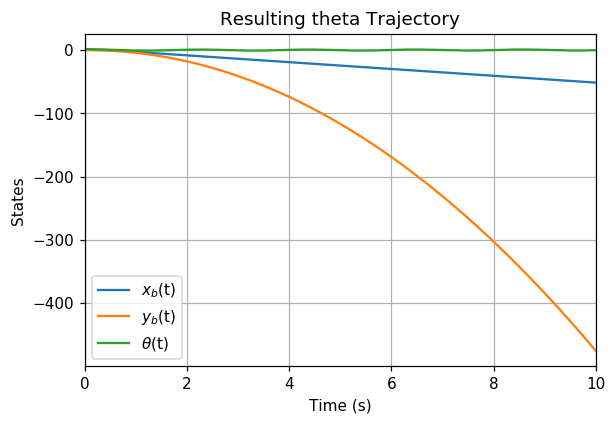

In [ ]:
# Numerical Simulation
tspan = [0,10]
dt = 0.05
x0 = np.array([0.3,0,0.1,0.3,np.pi/2,0])
N = int((max(tspan)-min(tspan))/dt)
tvec = np.linspace(min(tspan),max(tspan),N)

# Here we simulate ,psi_condition,impact_update
xvec = simulate_impact_2(dynamics,x0,tspan,dt,phi1_condition,impact_update_1)

# Here we plot
plt.figure(dpi=110,facecolor='w')
plt.plot(tvec,xvec[0])
plt.plot(tvec,xvec[2])
plt.plot(tvec,xvec[4])


plt.xlim(tspan)
plt.title('Resulting theta Trajectory')
plt.xlabel('Time (s)')
plt.ylabel('States')
plt.legend([r'$x_b$(t)',r'$y_b$(t)',r'$\theta$(t)'])
plt.grid(True)

In [ ]:
xpos=np.sin(xvec[4])
ypos=-np.cos(xvec[4])

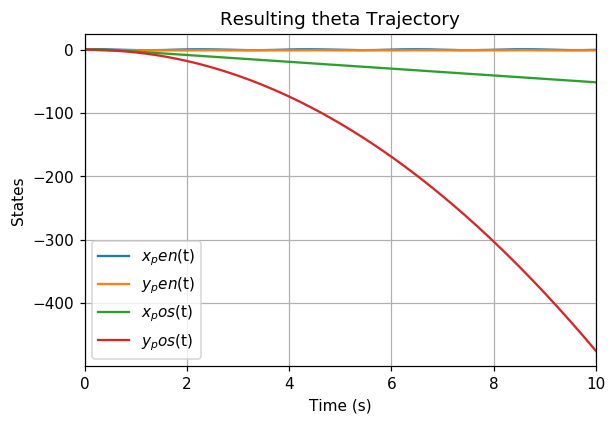

In [ ]:
plt.figure(dpi=110,facecolor='w')
plt.plot(tvec,xpos)
plt.plot(tvec,ypos)
plt.plot(tvec,xvec[0])
plt.plot(tvec,xvec[2])



plt.xlim(tspan)
plt.title('Resulting theta Trajectory')
plt.xlabel('Time (s)')
plt.ylabel('States')
plt.legend([r'$x_pen$(t)',r'$y_pen$(t)',r'$x_pos$(t)',r'$y_pos$(t)'])
plt.grid(True)

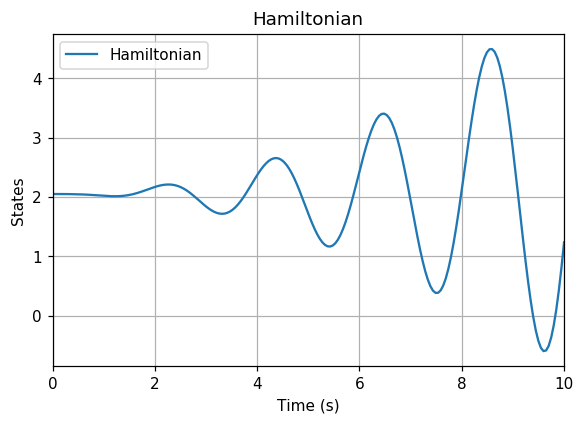

In [ ]:
# #Plot for hamilitonian added.
# #1903 after intererrupted impact
# Ham = H.subs({m:3,R:1,g:9.81,mb=2})
# Ham_dummy = Ham.subs({qdot[0]:vxbH,qdot[1]:vybH,qdot[2]:vthrH})
# lam_Hamiltonian = sym.lambdify([th,vth],Ham_dummy)



HAM = lam_Hamiltonian(xvec[0],xvec[1],xvec[2],xvec[3],xvec[4],xvec[5])
plt.figure(dpi=110,facecolor='w')
plt.plot(tvec,HAM)

plt.xlim(tspan)
plt.title('Hamiltonian')
plt.xlabel('Time (s)')
plt.ylabel('States')

plt.legend(['Hamiltonian'])
plt.grid(True)
plt.show()


In [ ]:
def animate(config_array,T=10):
    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    
    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
      import IPython
      display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)
    
    #################################
    # Getting data from trajectories.

    # Rect 1
    xx1_1=config_array[0]; yy1_1=config_array[1];
    xx2_1=config_array[2]; yy2_1=config_array[3];
    xx3_1=config_array[4]; yy3_1=config_array[5];
    xx4_1=config_array[6]; yy4_1=config_array[7];

    # Rect 2
    xx1_2=config_array[8]; yy1_2=config_array[9]
    xx2_2=config_array[10]; yy2_2=config_array[11]
    xx3_2=config_array[12]; yy3_2=config_array[13]
    xx4_2=config_array[14]; yy4_2=config_array[15]

    # Rect 3
    xx1_3=config_array[16]; yy1_3=config_array[17]
    xx2_3=config_array[18]; yy2_3=config_array[19]
    xx3_3=config_array[20]; yy3_3=config_array[21]
    xx4_3=config_array[22]; yy4_3=config_array[23]
    N = len(config_array[0]) # Need this for specifying length of simulation
    
    ####################################
    # Using these to specify axis limits.
    xm=-3
    xM=3
    ym=-8
    yM=3

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1_1, y=yy1_1, 
               mode='lines', name='Splits', 
               line=dict(width=2, color='blue')
              )
        ]
    
    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Splits Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[xx1_1[k],xx2_1[k],xx3_1[k],xx4_1[k],xx1_1[k],None,
                               xx1_2[k],xx2_2[k],xx3_2[k],xx4_2[k],xx1_2[k],None,
                               xx1_3[k],xx2_3[k],xx3_3[k],xx4_3[k],xx1_3[k]], 
                            y=[yy1_1[k],yy2_1[k],yy3_1[k],yy4_1[k],yy1_1[k],None,
                               yy1_2[k],yy2_2[k],yy3_2[k],yy4_2[k],yy1_2[k],None,
                               yy1_3[k],yy2_3[k],yy3_3[k],yy4_3[k],yy1_3[k]], 
                            mode='lines',
                            line=dict(color='black', width=2)
                            )
                      ]) for k in range(N)]
    
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)



In [ ]:
def animate_pend(x,y,theta_array,L1=1,T=10):
 
    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    
    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
      import IPython
      display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)
    
    ###############################################
    # Getting data from pendulum angle trajectories.
    xx2 = x
    yy2 = y
    xx1=L1*np.sin(theta_array[0])
    yy1=-L1*np.cos(theta_array[0])
    N = len(theta_array[0]) # Need this for specifying length of simulation
    
    ####################################
    # Using these to specify axis limits.
    xm=np.min(xx1)-0.5
    xM=np.max(xx1)+0.5
    ym=np.min(yy1)-2.5
    yM=np.max(yy1)+1.5

        # Rect 1
    # xx1_1=config_array[0]; yy1_1=config_array[1];
    # xx2_1=config_array[2]; yy2_1=config_array[3];
    # xx3_1=config_array[4]; yy3_1=config_array[5];
    # xx4_1=config_array[6]; yy4_1=config_array[7];


    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Pendulum', 
               line=dict(width=2, color='blue')
              ),
          # dict(x=xx1, y=yy1, 
          #      mode='lines', name='Mass Traj.',
          #      line=dict(width=2, color='purple')
              # ),
          dict(x=xx2, y=yy2, 
               mode='lines', name='Mass Traj.',
               line=dict(width=2, color='green')
              )
          # ,
          # dict(x=xx1_1, y=yy1_1, 
          #      mode='lines', name='Splits', 
          #      line=dict(width=2, color='blue')
          #     )
        ]
    
    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Single Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[0,xx1[k]], 
                            y=[0,yy1[k]], 
                            mode='lines',
                            line=dict(color='red', width=7),
                            


                            ),
                       


                      
                       ]) for k in range(N)]



                 

    # frames=[dict(data=[dict(x=[xx1_1[k],xx2_1[k],xx3_1[k],xx4_1[k],xx1_1[k],None], 
    #                         y=[yy1_1[k],yy2_1[k],yy3_1[k],yy4_1[k],yy1_1[k],None], 
    #                         mode='lines',
    #                         line=dict(color='black', width=2)
    #                         )
    #                   ]) for k in range(N)]
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)


                            

In [ ]:
theta_array = np.array([xvec[4]])
x = xvec[0]
y = xvec[2]
#animate_pend(x,y,theta_array,1,10)

In [ ]:
def animate_pend2(config_array,theta_array,L1=1,T=10):
 
    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    
    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
      import IPython
      display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)
    
    ###############################################
    # Getting data from pendulum angle trajectories.
    xx1=L1*np.sin(theta_array[0])
    yy1=-L1*np.cos(theta_array[0])
    N = len(theta_array[0]) # Need this for specifying length of simulation
    
    ####################################
    # Using these to specify axis limits.
    xm=np.min(xx1)-0.5
    xM=np.max(xx1)+0.5
    ym=np.min(yy1)-2.5
    yM=np.max(yy1)+1.5

        # Rect 1
    xx1_1=config_array[0]; yy1_1=config_array[1];
    xx2_1=config_array[2]; yy2_1=config_array[3];
    xx3_1=config_array[4]; yy3_1=config_array[5];
    xx4_1=config_array[6]; yy4_1=config_array[7];

        #Rect2
    xx1_2=config_array[8]; yy1_2=config_array[9]
    xx2_2=config_array[10]; yy2_2=config_array[11]
    xx3_2=config_array[12]; yy3_2=config_array[13]
    xx4_2=config_array[14]; yy4_2=config_array[15]


    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Pendulum', 
               line=dict(width=2, color='blue')
              ),
          dict(x=xx1, y=yy1, 
               mode='lines', name='Mass Traj.',
               line=dict(width=2, color='purple')
              ),
          dict(x=xx1_1, y=yy1_1, 
               mode='lines', name='Splits', 
               line=dict(width=2, color='blue')
              )
        ]
    
    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Single Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[xx1_1[k],xx2_1[k],xx3_1[k],xx4_1[k],xx1_1[k],None,
                               xx1_2[k],xx2_2[k],xx3_2[k],xx4_2[k],xx1_2[k],None,], 
                            y=[yy1_1[k],yy2_1[k],yy3_1[k],yy4_1[k],yy1_1[k],None,
                               yy1_2[k],yy2_2[k],yy3_2[k],yy4_2[k],yy1_2[k],None,], 
                            mode='lines',
                            line=dict(color='black', width=2)
                            ),
                       dict(x=[0,xx1[k]], 
                            y=[0,yy1[k]], 
                            mode='lines',
                            line=dict(color='red', width=7)
                            ),
                      ]) for k in range(N)]
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)


                            

In [ ]:
# Init
wax = np.array([0,0,1])
x1 = xvec[0]; y1 = xvec[2]
thet1 = np.zeros(x1.shape[0])
x2 = xpos; y2 = ypos
thet2 = np.zeros(x2.shape[0])
# x3 = np.zeros(x2.shape[0]); y3 = np.zeros(x2.shape[0])
# thet3 = xvec[8]
rec1 = np.zeros((8,x1.shape[0])) 
rec2 = np.zeros((8,x1.shape[0])) 
# rec3 = np.zeros((8,x1.shape[0])) 

# Getting rectangle points at each time step
for i in range(x1.shape[0]):
    rec1[:,i] = rectangle_t(x1[i],y1[i],thet1[i],0.1,0.1)
    rec2[:,i] = rectangle(x2[i],y2[i],thet2[i],0.2,0.2)
   # rec3[:,i] = rectangle(x3[i],y3[i],thet3[i],2,0.6)

# Putting points in the form animate() expects
config_array = np.vstack([rec1,rec2])
theta_array = np.array([xvec[4]])

In [ ]:
theta_array = np.array([xvec[4]])
animate_pend2(config_array,theta_array,1,10)

In [ ]:
xvec[2]
y_b=xvec[2]
xvec[0]
x_b=xvec[0]

In [ ]:
def animate_pend_ball(config_array,theta_array,x_b,y_b,L1=1,T=10):
 
    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    
    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
      import IPython
      display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)
    
    ###############################################
    # Getting data from pendulum angle trajectories.
    xx1=L1*np.sin(theta_array[0])
    yy1=-L1*np.cos(theta_array[0])
    N = len(theta_array[0]) # Need this for specifying length of simulation
    
            # Rect 1
    xx1_1=config_array[0]; yy1_1=config_array[1];
    xx2_1=config_array[2]; yy2_1=config_array[3];
    xx3_1=config_array[4]; yy3_1=config_array[5];
    xx4_1=config_array[6]; yy4_1=config_array[7]

    ####################################
    # Using these to specify axis limits.
    xm=np.min(xx1)-0.5
    xM=np.max(xx1)+0.5
    ym=np.min(yy1)-2.5
    yM=np.max(yy1)+1.5



    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Pendulum', 
               line=dict(width=2, color='blue')
              ),
          dict(x=xx1, y=yy1, 
               mode='lines', name='Mass Traj.',
               line=dict(width=2, color='purple')
              ),
          dict(x=xb, y=yb, 
               mode='lines', name='xb.',
               line=dict(width=2, color='green')
              )
               ]
    data=[dict(x=xx1_1, y=yy1_1, 
               mode='lines', name='Splits', 
               line=dict(width=2, color='blue')
              )
        ]
              


  

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Single Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    # frames=[dict(data=[dict(x=xb, 
    #                         y=yb, 
    #                         mode='circles',
    #                         line=dict(color='blue', width=7)
    #                         )
    #                   ]) for k in range(N)],

    frames=[dict(data=[dict(x=[0,xx1[k]], 
                            y=[0,yy1[k]], 
                            mode='lines',
                            line=dict(color='red', width=7)
                            )
                      ]) for k in range(N)],


    frames=[dict(data=[dict(x=[xx1_1[k],xx2_1[k],xx3_1[k],xx4_1[k],xx1_1[k],None], 
                            y=[yy1_1[k],yy2_1[k],yy3_1[k],yy4_1[k],yy1_1[k],None], 
                            mode='lines',
                            line=dict(color='black', width=2)
                            )
                      ]) for k in range(N)]                      

                      
    
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

In [ ]:
#xvec[0].shape

In [ ]:
# x0=xvec[0]
# y0=xvec[2]

In [ ]:
# animate_pend_ball(theta_array,x0,y0,L1=1,T=10)

In [ ]:
#animate(conf_array)